#### Script 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
%matplotlib inline

SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches


# script 2 - takes in standards.txt and a list of FITS files
#
# write out for each image:
# loop throuhg the standards stars:
#     find the photometry from the current FITS image
#     IF star is not found (or bad data) write out NaN in the column
#
# write out for each image file:
#
# the name of the image file, the EPOCH, the FILTER, the AIRMASS, the FLUX and FLUXERR of J0600, (FLUX and FLUXERR for 20 stars)
# use and ECSV format (because it remembers the names of the columns and deals with 'Quantity' columns too....)


# make a plot of flux versus epoch (which is in MJD) for 

In [2]:
# First write out for one file:
#  the name of the image file, the EPOCH, the FILTER, the AIRMASS, the FLUX and FLUXERR of J0600, (FLUX and FLUXERR for 20 stars)
#  use and ECSV format (because it remembers the names of the columns and deals with 'Quantity' columns too....)

standards = ascii.read("standards.txt", guess=False)
coord_world = np.array([standards['RA'],standards['Dec']]).transpose()
nr_stars = len(coord_world[:,0])
print('Number of stars = {}'.format(nr_stars))


filename = '..//data/coj1m003-fa19-20210112-0083-e91.fits.fz'

hdu1 = fits.open(filename)

imh = hdu1['SCI'].header
phot = hdu1['cat'].data

epoch = imh['MJD-OBS']
obs_filter = imh['FILTER']
airmass = imh['AIRMASS']
pix_asec = imh['PIXSCALE'] # Nominal pixel scale on sky [arcsec/pixel]
print('Epoch = {:.5f} MJD'.format(epoch))
print('Filter = {}'.format(obs_filter))
print('AIRMASS = {:.5f}'.format(airmass))

Number of stars = 44
Epoch = 59226.45471 MJD
Filter = gp
AIRMASS = 1.07476


In [3]:
# Transform coordinates from realworld to pixels in image
w = wcs.WCS(hdu1['SCI'].header)

coord = w.wcs_world2pix(coord_world,0)

Set OBSGEO-B to   -31.273025 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


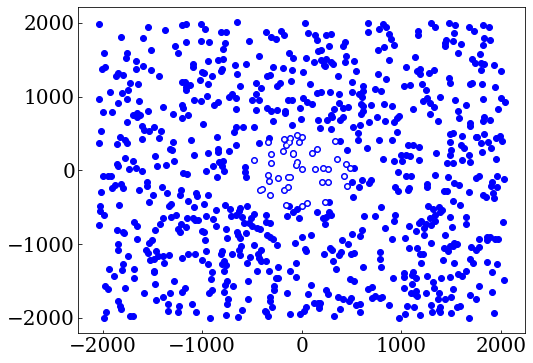

In [4]:
# functie(lijst met pixel_coordinaten van standards, lijst met pixel coordinaten huidige sterren):
#   reken afstanden uit
#   Test of afstand voldoende klein is (print afstanden)
#   
#   return index dichtbijzijndste ster voor elke ingevoerde ster

def find_stars(xobj_list, yobj_list, xlist, ylist):
    #print (xobj_list)
    #print (yobj_list)
    #print (xlist)
    #print (ylist)
    
    plt.scatter(xlist-2048,ylist-2048,c='b',)
    plt.scatter(xobj_list-2048, yobj_list-2048, c='white',marker='.')
    #plt.axis(xmin=-800,xmax=800,ymin=-800,ymax=800)
    plt.show()
    
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    
    return indices, np.diag(distance_matrix[indices]) #the daigonal gives the distance from each point to the star


stars_arg, d = find_stars(coord[:,0],coord[:,1], phot['x'], phot['y'])

In [5]:
flux_stars = np.zeros(nr_stars)
fluxerr_stars = np.zeros(nr_stars)
for i in range(nr_stars):
    flux_stars[i] = phot['flux'][stars_arg[i]]
    fluxerr_stars[i] = phot['fluxerr'][stars_arg[i]]

In [6]:
newfilename = filename.replace('data','datared').replace('.fits.fz', '.txt')


#VERY cheap fix for "ValueError: Inconsistent data column lengths: {1, 44}", must be a better way
# maybe use 2 different files, maybe
nanlist = [np.NaN]*(nr_stars-1)

obj = [filename.replace('..//data/','').replace('fits.fz','')]
obj.extend(nanlist)
epoch = [imh['MJD-OBS']]
epoch.extend(nanlist)
obs_filter = [imh['FILTER']]
obs_filter.extend(nanlist)
airmass = [imh['AIRMASS']]
airmass.extend(nanlist)


# Write data to Table and then to file
filecontent = Table([obj, epoch, obs_filter, airmass, flux_stars, fluxerr_stars],\
                    names=['IMAGE','EPOCH','FILTER','AIRMASS','FLUX','FLUXERR'])
ascii.write(filecontent, newfilename, overwrite=True)

In [7]:
#use this code to select all images
from pathlib import Path

#selects all names in ../data/
for name in Path('..//data/').rglob('*e91.fits.fz'):
    print (name)
    print (str(name).replace('data','datared'))

../data/coj1m003-fa19-20210113-0098-e91.fits.fz
../datared/coj1m003-fa19-20210113-0098-e91.fits.fz
../data/coj1m011-fa12-20210111-0235-e91.fits.fz
../datared/coj1m011-fa12-20210111-0235-e91.fits.fz
../data/coj1m003-fa19-20210112-0084-e91.fits.fz
../datared/coj1m003-fa19-20210112-0084-e91.fits.fz
../data/coj1m003-fa19-20210117-0070-e91.fits.fz
../datared/coj1m003-fa19-20210117-0070-e91.fits.fz
../data/coj1m011-fa12-20210116-0174-e91.fits.fz
../datared/coj1m011-fa12-20210116-0174-e91.fits.fz
../data/lsc1m004-fa03-20210111-0142-e91.fits.fz
../datared/lsc1m004-fa03-20210111-0142-e91.fits.fz
../data/cpt1m012-fa06-20210118-0060-e91.fits.fz
../datared/cpt1m012-fa06-20210118-0060-e91.fits.fz
../data/lsc1m004-fa03-20210111-0141-e91.fits.fz
../datared/lsc1m004-fa03-20210111-0141-e91.fits.fz
../data/coj1m011-fa12-20210112-0135-e91.fits.fz
../datared/coj1m011-fa12-20210112-0135-e91.fits.fz
../data/coj1m003-fa19-20210113-0096-e91.fits.fz
../datared/coj1m003-fa19-20210113-0096-e91.fits.fz
../data/ls